In [16]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [17]:
max_iteration = 30000
weight_decay = 0.01
NUM_EMPLOYEES = 5500
NUM_TRAIN = 5000
NUM_VAL = 500
Upsilon_1 = 0.01
Upsilon_2 = 0.01
NUM_FEATURES = 5
BANDWIDTH = 1

In [19]:
X = np.random.normal(loc=0.0, scale=10.0, size=(NUM_EMPLOYEES, NUM_FEATURES)) # the training set

survival_times = np.zeros(NUM_EMPLOYEES) # the surivial time of each employees
for i in range(NUM_EMPLOYEES):
    # age = np.random.exponential(np.sum(Upsilon_1 * X[i,:] ** 2), size=1)
    _lambda = np.sum(Upsilon_1 * X[i,:] ** 2)
    age = _lambda*np.exp(-1 * _lambda * (time.time() % 10 * 0.001))
    survival_times[i] = np.ceil(age)
    print(age)
    
maximum_ob_time = int(max(survival_times))   

Y = np.ones((NUM_EMPLOYEES, maximum_ob_time)) # the lifetime matrix of all employees, if one employee leave at the time interval k, then from Y[i,k](inlcude)  all entries are -1
for i in range(NUM_EMPLOYEES):
    Y[i, int(survival_times[i])-1:] = -1
    
square = np.sum(X ** 2, axis=1)
column_vec = square[:, np.newaxis]
row_vec = square[np.newaxis, :]
Gaussian_Kernel = np.exp(-1 * (-2 * X.dot(X.T) + column_vec + row_vec) / (2 * BANDWIDTH ** 2)) # the Gaussian Kernel
Gaussian_Kernel_Train = Gaussian_Kernel[:NUM_TRAIN,:NUM_TRAIN]
Gaussian_Kernel_Val = Gaussian_Kernel[NUM_TRAIN:,:NUM_TRAIN]

2.7547339472681465
1.0509937664910296
3.9706617300831435
5.557488175219244
6.003598518675381
3.4578424487643025
3.6040791370811176
6.287703724890165
4.672691181236676
2.2951363426456335
2.5936843122643336
8.488618174449986
4.512351970956382
6.039266242508359
2.5816337392666067
3.9832920288467992
11.269753740375943
1.5197017354596236
4.5879365739769415
1.917233407730799
4.457983270717939
3.7736083262909648
5.184996077371107
4.862865889401358
3.786456721068514
10.80452635765907
6.792770127188533
3.833891907649828
3.427356963394552
4.081539961210196
5.493797042388163
3.059115797719083
3.6601982372331574
1.006379940221931
8.120029797238708
9.052833755085901
2.2738216947984395
8.205173161588652
7.275438617174852
2.7144156082245505
4.7787937161994005
8.242667931981645
1.8440514931680527
13.740222386127332
3.083444874898405
3.173712168221917
1.495979078273212
0.8399997584722724
5.706146337877918
3.512675043480865
2.257439333691195
11.858106693616438
6.02258198383174
0.9571548140139919
1.25768

11.877045095937826
2.8622418695507172
5.627530630432201
7.398038653006759
2.2368925340033474
2.34952066602062
2.2953461496028256
5.452550519454285
3.126224384451211
1.3628177429232438
4.785853701905745
5.47484316498891
7.657884929771596
1.1847311768213953
3.7529227026707437
4.098895893552275
2.145693449491286
4.999387963409728
3.4255196305711113
2.86181601206698
1.6954862177752377
1.1121708195541407
3.753844962904666
3.9019058311918817
8.00976400527969
5.876616171181977
0.38875521247599026
2.7973747782075913
9.402043352568182
5.15099090085
9.30872356702317
3.591978763461018
5.094250261849273
0.7739301294709829
3.8907633471674608
2.794263549896787
4.066365369397266
11.172253482212405
3.8599484365209173
15.188381860869466
6.03071533185563
4.992591412747326
2.540908838993128
5.1017816604838515
4.3042943812811165
2.0351027189167135
4.605339642686754
3.979407416388762
1.095346559946628
2.974391725653944
3.179579178170839
10.984460906602987
2.288953915105157
6.244193634806187
0.5236755729147

In [21]:
X_train = X[:NUM_TRAIN]
X_val = X[NUM_TRAIN:]
Y_train = Y[:NUM_TRAIN]
Y_val = Y[NUM_TRAIN:]

In [22]:
alpha = np.zeros_like(Y_train) 
# alpha = np.ones_like(Y_train)
predict_age = np.zeros(NUM_EMPLOYEES) 
val_loss_list = []
for t in range(1, max_iteration+1):
    index = int(np.floor(np.random.rand()*NUM_TRAIN)) # randomly select one employee
    haty_index = (Gaussian_Kernel_Train[index,:][np.newaxis,:].dot(alpha * Y_train)).reshape(-1) # calculate the predicted y vector
    haty_index /= t * weight_decay

    ## update alpha

    mask = Y_train[index,:]*haty_index < 1
    alpha[index,] += mask

    if t%1000 == 0 or t == 1:
        print("the iteration is:", t)
        hatY_train = np.zeros_like(Y_train)
        hatY_train += Gaussian_Kernel_Train.dot(alpha*Y_train)
        hatY_train /= t * weight_decay
        
        hatY_val = np.zeros_like(Y_val)
        hatY_val += Gaussian_Kernel_Val.dot(alpha*Y_train)
        hatY_val /= t * weight_decay
        
        for i in range(NUM_TRAIN):
            predict_age[i] = np.sum(hatY_train[i,:] > 0) + 1
        for i in range(NUM_TRAIN,NUM_EMPLOYEES):
            predict_age[i] = np.sum(hatY_val[i-NUM_TRAIN,:] > 0) + 1
        
        acc_train = np.sum(Y_train * hatY_train > 0) / (NUM_TRAIN * maximum_ob_time)
        acc_val = np.sum(Y_val * hatY_val > 0) / (NUM_VAL * maximum_ob_time)
        print("the train accuracy is:", acc_train)
        print("the val accuracy is:", acc_val)
        
        '''
     
        val_result = hatY_val * Y[NUM_TRAIN:]
        mask = val_result < 0
        
        val_loss = np.sum(val_result < 0) - np.sum(val_result[mask])
        if t == 1 or v/al_loss < loss_list[-1]:
            val_loss_list.append(val_loss)
        
        '''
        
        useful_pair = 0.0
        denominator = NUM_VAL*(NUM_VAL-1)/2
        
        for i in range(NUM_TRAIN, NUM_EMPLOYEES):
            for j in range(i+1, NUM_EMPLOYEES):
                if (survival_times[i]-survival_times[j])*(predict_age[i]-predict_age[j])> 0: # useful pair
                    useful_pair += 1
                if  survival_times[i] == survival_times[j]: # two employees whose lifetime are identical
                    denominator -= 1
        
        c_index = useful_pair / denominator
        print("useful_pair", useful_pair)
        print("denominator", denominator)
        print("the c-index for VALIDATION is,",c_index)
        
print(np.sum(predict_age[NUM_TRAIN:] == survival_times[NUM_TRAIN:])/(NUM_VAL))

the iteration is: 1
the train accuracy is: 0.4175
the val accuracy is: 0.39554545454545453
useful_pair 14912.0
denominator 109393.0
the c-index for VALIDATION is, 0.13631585201978189
the iteration is: 1000
the train accuracy is: 0.9570090909090909
the val accuracy is: 0.9473636363636364
useful_pair 87104.0
denominator 109393.0
the c-index for VALIDATION is, 0.79624838883658
the iteration is: 2000
the train accuracy is: 0.968790909090909
the val accuracy is: 0.9563636363636364
useful_pair 91015.0
denominator 109393.0
the c-index for VALIDATION is, 0.8320002193924657
the iteration is: 3000
the train accuracy is: 0.9755909090909091
the val accuracy is: 0.9572727272727273
useful_pair 91465.0
denominator 109393.0
the c-index for VALIDATION is, 0.8361138281242858
the iteration is: 4000
the train accuracy is: 0.9810545454545454
the val accuracy is: 0.9584545454545454
useful_pair 91783.0
denominator 109393.0
the c-index for VALIDATION is, 0.8390207782947721
the iteration is: 5000
the train acc

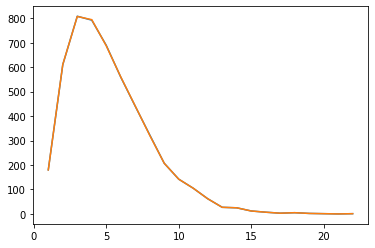

In [23]:
x_axis = np.arange(maximum_ob_time)+1
y_train_gt_axis = np.zeros(maximum_ob_time)
y_val_gt_axis = np.zeros(maximum_ob_time)
y_train_predict_axis = np.zeros(maximum_ob_time)
y_val_predict_axis = np.zeros(maximum_ob_time)

for i in range(maximum_ob_time):
    y_train_gt_axis[i] = np.sum(survival_times[:NUM_TRAIN] == x_axis[i])
    y_val_gt_axis[i] = np.sum(survival_times[NUM_TRAIN:] == x_axis[i])
    y_train_predict_axis[i] = np.sum(predict_age[:NUM_TRAIN] == x_axis[i])
    y_val_predict_axis[i] = np.sum(predict_age[NUM_TRAIN:] == x_axis[i])
plt.plot(x_axis, y_train_gt_axis, x_axis, y_train_predict_axis)
# plt.plot(x_axis, y_val_gt_axis, x_axis, y_val_predict_axis)


In [24]:
print(np.sum(survival_times[NUM_TRAIN:] - predict_age[NUM_TRAIN:] < 0))
print(np.sum(survival_times[NUM_TRAIN:] - predict_age[NUM_TRAIN:] > 0))
print(print(np.sum(survival_times[NUM_TRAIN:] - predict_age[NUM_TRAIN:] == 0)))
print(survival_times[NUM_TRAIN:])
print(predict_age[NUM_TRAIN:])

99
196
205
None
[ 7.  4.  3.  3.  6.  3.  9.  4.  3.  4. 12.  3.  3. 10.  6.  5.  3.  3.
  8.  6. 11.  2.  7.  4.  2.  4.  4.  5.  3.  7.  5.  3.  6.  2.  6.  6.
  2.  9.  1.  1.  1.  6.  5.  2.  7.  3.  4.  4.  5.  4.  8.  4.  4.  8.
  5.  2.  4.  5.  7.  5.  5.  4.  4.  2.  8.  7.  2. 15.  2.  5.  3.  6.
  3.  5.  3.  4.  6.  6.  6.  6.  2.  4.  1.  3.  7.  4.  7.  4.  4.  4.
  6.  4.  1.  4.  4.  2. 12.  7.  6.  6.  8.  2.  2.  5.  6.  5.  3.  4.
  3.  3.  9.  1.  4.  1.  8.  9.  5.  5.  5.  3.  6.  5. 10.  8.  6.  6.
  5.  3.  5.  3.  6. 15.  2.  4. 12. 10.  5.  4.  1.  4.  4.  1.  3.  4.
  8. 14.  4.  2.  4.  8.  3.  8.  3.  2.  9.  6.  4.  3.  2.  8.  4.  6.
  4.  3.  8.  5.  2. 12.  6.  5.  6.  6.  8.  8.  6.  6.  3.  3.  6.  4.
 11.  2.  6.  5.  3.  5.  2.  3.  6.  3.  5.  3.  4.  4.  5.  4.  6.  4.
 12.  7.  7.  3.  4.  3. 12.  8.  5.  7.  3.  2.  3.  5.  4.  4.  3.  6.
  4.  5.  2.  4.  3.  2.  3.  1.  5.  9.  8.  2.  4.  8.  2.  6.  7.  5.
  5.  4.  4.  2.  2.  6.  3.  5.  6

In [9]:
hatY_val = np.zeros_like(Y_val)
hatY_val += Gaussian_Kernel_Val.dot(alpha*Y_train)
hatY_val /= t * weight_decay

In [10]:
print(np.sum(alpha < 0))

0


In [11]:
np.set_printoptions(threshold=np.inf)
hatY_val = np.zeros_like(Y_val)
hatY_val += Gaussian_Kernel_Val.dot(alpha*Y_train)
hatY_val /= t * weight_decay


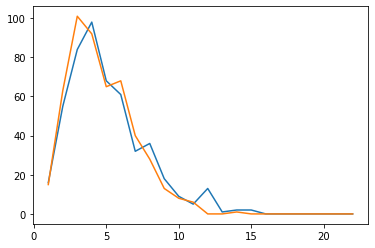

In [25]:
x_axis = np.arange(maximum_ob_time)+1
plt.plot(x_axis, y_val_gt_axis, x_axis, y_val_predict_axis)

In [13]:
useful_pair = 0.0
denominator = 5*(5-1)/2
A = [3,4, 5, 1, 2]
B = [2, 5, 8 ,9 ,10]
for i in range(5):
    for j in range(i+1, 5):
        if (A[i]-A[j])*(B[i]-B[j])> 0: # useful pair
            useful_pair += 1
        if  A[i] == B[j]: # two employees whose lifetime are identical
            denominator -= 1
        
c_index = useful_pair / denominator
print(c_index)

0.4


90.483741803596 5.684341886080802e-14


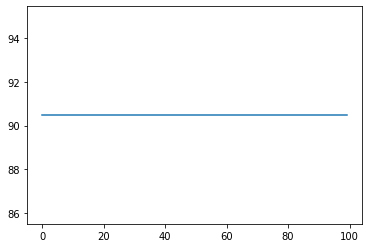

In [26]:
num_samples = 100
feature_matrix =np.ones((num_samples,num_samples))
age_list = []
for sample in feature_matrix:
    _lambda = np.sum(sample ** 2)
    # age = np.random.exponential(_lambda, size=1)
    age = _lambda*np.exp(-1 * _lambda * 0.001)
    age_list.append(age)
    
plt.plot(range(num_samples),age_list)
print(np.mean(age_list), np.std(age_list))